# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 9

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_all_genes"
    / "gls-1000g_mashr-test-full_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_all_genes/gls-1000g_mashr-test-full_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lv = results["lv"].unique()
    assert len(observed_lv) == 1
    observed_lv = observed_lv[0]

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_all_genes/gls-1000g_mashr-test-full_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_all_genes/gls-1000g_mashr-test-full_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_all_genes/gls-1000g_mashr-test-full_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_all_genes/gls-1000g_mashr-test-full_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_all_genes/gls-1000g_mashr-test-full_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(9000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV45,0.010457,0.008592,1.217035,0.223635,0.111818,random.pheno988
1,LV234,0.016077,0.010588,1.518377,0.128968,0.064484,random.pheno988
2,LV847,0.002250,0.010898,0.206501,0.836406,0.418203,random.pheno988
3,LV110,-0.022703,0.008878,-2.557311,0.010571,0.994714,random.pheno988
4,LV769,0.014277,0.010238,1.394498,0.163215,0.081608,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.06711111111111111

It should be around 0.05. Let's check what happened at individual LVs.

# Summary of mean type I error per LV

In [18]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [19]:
summary_df.shape

(9, 4)

In [20]:
summary_df.head()

,lv,1,5,10
0,LV110,0.016,0.051,0.095
1,LV234,0.015,0.057,0.102
2,LV412,0.001,0.009,0.022
3,LV45,0.046,0.105,0.153
4,LV57,0.009,0.056,0.108


In [21]:
summary_df.describe()

,1,5,10
count,9.000000,9.000000,9.000000
mean,0.020444,0.067111,0.111889
std,0.018756,0.038722,0.049319
min,0.001000,0.009000,0.022000
25%,0.009000,0.051000,0.098000
50%,0.015000,0.056000,0.106000
75%,0.022000,0.078000,0.116000
max,0.057000,0.145000,0.207000


## LVs with expected type I error

In [22]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(1, 4)

,lv,1,5,10
0,LV110,0.016,0.051,0.095


,lv,1,5,10
0,LV110,0.016,0.051,0.095


## LVs with high type I error

In [23]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(3, 4)

,lv,1,5,10
5,LV647,0.022,0.078,0.116
3,LV45,0.046,0.105,0.153
6,LV769,0.057,0.145,0.207


Many LVs have a mean type I error greater than expected.

LV45 has the largest mean type I error (0.158). Let's take a look at these LVs with poor mean type I errors.

# LVs with high mean type I error

In [24]:
lv_results_high = {}

## LV45

In [25]:
lv_code = "LV45"

In [26]:
results = dfs[dfs["lv"] == lv_code]

In [27]:
results.shape

(1000, 7)

In [28]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV45,0.010457,0.008592,1.217035,0.223635,0.111818,random.pheno988
9,LV45,0.002799,0.008646,0.323773,0.746121,0.373060,random.pheno589
18,LV45,0.001017,0.008573,0.118626,0.905576,0.452788,random.pheno385
27,LV45,0.003885,0.008677,0.447693,0.654390,0.327195,random.pheno5
36,LV45,-0.018163,0.008598,-2.112587,0.034674,0.982663,random.pheno74


In [29]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [30]:
show_prop(results, 0.01)

0.046

In [31]:
show_prop(results, 0.05)

0.105

In [32]:
show_prop(results, 0.10)

0.153

In [33]:
show_prop(results, 0.15)

0.2

In [34]:
show_prop(results, 0.20)

0.237

### QQplot

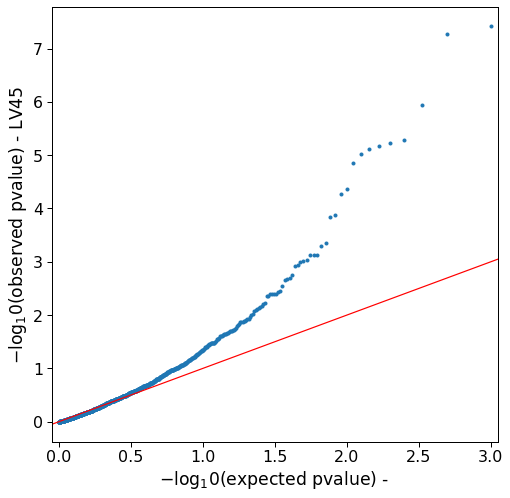

In [35]:
qqplot_unif(results)

## LV234

In [36]:
lv_code = "LV234"

In [37]:
results = dfs[dfs["lv"] == lv_code]

In [38]:
results.shape

(1000, 7)

In [39]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
1,LV234,0.016077,0.010588,1.518377,0.128968,0.064484,random.pheno988
10,LV234,0.003390,0.010656,0.318114,0.750409,0.375205,random.pheno589
19,LV234,-0.004410,0.010565,-0.417380,0.676415,0.661793,random.pheno385
28,LV234,0.004889,0.010693,0.457216,0.647531,0.323766,random.pheno5
37,LV234,0.003831,0.010599,0.361484,0.717750,0.358875,random.pheno74


In [40]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [41]:
show_prop(results, 0.01)

0.015

In [42]:
show_prop(results, 0.05)

0.057

In [43]:
show_prop(results, 0.10)

0.102

In [44]:
show_prop(results, 0.15)

0.153

In [45]:
show_prop(results, 0.20)

0.202

### QQplot

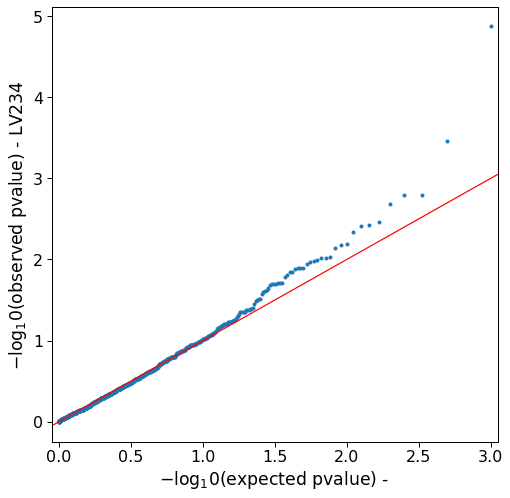

In [46]:
qqplot_unif(results)

## LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
2,LV847,0.002250,0.010898,0.206501,0.836406,0.418203,random.pheno988
11,LV847,-0.002987,0.010966,-0.272374,0.785343,0.607328,random.pheno589
20,LV847,-0.012870,0.010871,-1.183860,0.236512,0.881744,random.pheno385
29,LV847,-0.003763,0.011005,-0.341951,0.732399,0.633801,random.pheno5
38,LV847,0.007045,0.010907,0.645930,0.518347,0.259174,random.pheno74


In [51]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.008

In [53]:
show_prop(results, 0.05)

0.055

In [54]:
show_prop(results, 0.10)

0.098

In [55]:
show_prop(results, 0.15)

0.139

In [56]:
show_prop(results, 0.20)

0.178

### QQplot

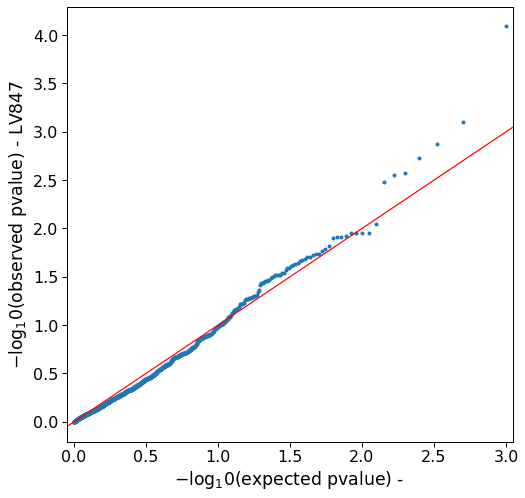

In [57]:
qqplot_unif(results)

## LV110

In [58]:
lv_code = "LV110"

In [59]:
results = dfs[dfs["lv"] == lv_code]

In [60]:
results.shape

(1000, 7)

In [61]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
3,LV110,-0.022703,0.008878,-2.557311,0.010571,0.994714,random.pheno988
12,LV110,-0.012941,0.008936,-1.448216,0.147605,0.926197,random.pheno589
21,LV110,-0.008632,0.008861,-0.974212,0.329988,0.835006,random.pheno385
30,LV110,-0.008344,0.008969,-0.930361,0.352219,0.823890,random.pheno5
39,LV110,0.009092,0.008889,1.022792,0.306445,0.153222,random.pheno74


In [62]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [63]:
show_prop(results, 0.01)

0.016

In [64]:
show_prop(results, 0.05)

0.051

In [65]:
show_prop(results, 0.10)

0.095

In [66]:
show_prop(results, 0.15)

0.143

In [67]:
show_prop(results, 0.20)

0.19

### QQplot

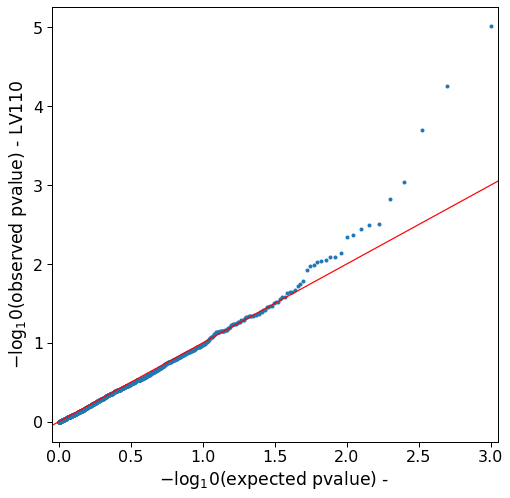

In [68]:
qqplot_unif(results)

## LV769

In [69]:
lv_code = "LV769"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 7)

In [72]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
4,LV769,0.014277,0.010238,1.394498,0.163215,0.081608,random.pheno988
13,LV769,-0.006908,0.010303,-0.670474,0.502580,0.748710,random.pheno589
22,LV769,-0.011049,0.010214,-1.081684,0.279434,0.860283,random.pheno385
31,LV769,-0.014140,0.010338,-1.367813,0.171418,0.914291,random.pheno5
40,LV769,-0.017678,0.010246,-1.725373,0.084508,0.957746,random.pheno74


In [73]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [74]:
show_prop(results, 0.01)

0.057

In [75]:
show_prop(results, 0.05)

0.145

In [76]:
show_prop(results, 0.10)

0.207

In [77]:
show_prop(results, 0.15)

0.261

In [78]:
show_prop(results, 0.20)

0.317

### QQplot

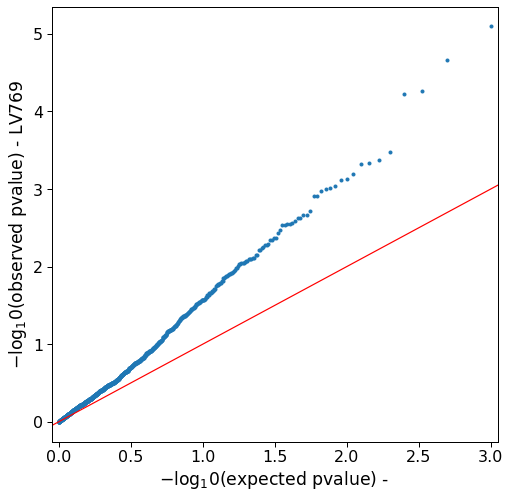

In [79]:
qqplot_unif(results)

The QQplot here is not the same as the LVs before. In previous LVs, there are very small pvalues, likely because of the genes from the same region at the top of the LV.

Here p-values are consistently smaller than expected, but there are no very small p-values.

## LV800

In [80]:
lv_code = "LV800"

In [81]:
results = dfs[dfs["lv"] == lv_code]

In [82]:
results.shape

(1000, 7)

In [83]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
5,LV800,0.004962,0.012470,0.397942,0.690686,0.345343,random.pheno988
14,LV800,-0.012850,0.012547,-1.024163,0.305797,0.847102,random.pheno589
23,LV800,-0.003878,0.012441,-0.311740,0.755248,0.622376,random.pheno385
32,LV800,-0.015103,0.012591,-1.199540,0.230362,0.884819,random.pheno5
41,LV800,-0.009510,0.012481,-0.761968,0.446107,0.776947,random.pheno74


In [84]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [85]:
show_prop(results, 0.01)

0.01

In [86]:
show_prop(results, 0.05)

0.048

In [87]:
show_prop(results, 0.10)

0.106

In [88]:
show_prop(results, 0.15)

0.151

In [89]:
show_prop(results, 0.20)

0.201

### QQplot

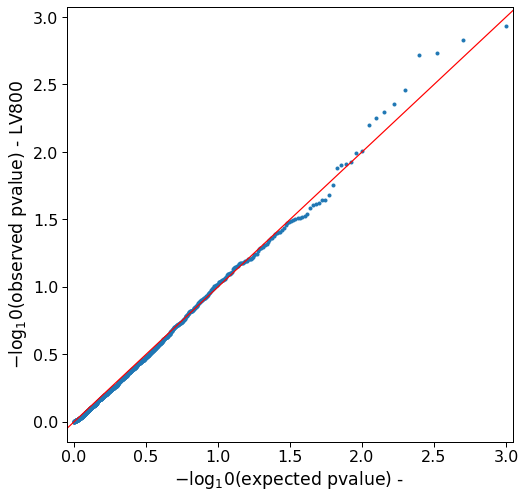

In [90]:
qqplot_unif(results)

**Note**: looks similar to LV769. This one has smaller minimum p-values.

# LVs with expected mean type I error

In [91]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
0,LV110,0.016,0.051,0.095


Here I'm manually selecting from this list, since I want those that are well calibrated across different p-value thresholds.

In [92]:
lv_results_expected = {}

## LV412

In [93]:
lv_code = "LV412"

In [94]:
results = dfs[dfs["lv"] == lv_code]

In [95]:
results.shape

(1000, 7)

In [96]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
6,LV412,-0.000049,0.006321,-0.007811,0.993768,0.503116,random.pheno988
15,LV412,-0.003479,0.006360,-0.547042,0.584369,0.707815,random.pheno589
24,LV412,0.002794,0.006306,0.443127,0.657689,0.328844,random.pheno385
33,LV412,-0.002079,0.006383,-0.325806,0.744582,0.627709,random.pheno5
42,LV412,0.005197,0.006326,0.821516,0.411383,0.205691,random.pheno74


In [97]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [98]:
show_prop(results, 0.01)

0.001

In [99]:
show_prop(results, 0.05)

0.009

In [100]:
show_prop(results, 0.10)

0.022

In [101]:
show_prop(results, 0.15)

0.061

In [102]:
show_prop(results, 0.20)

0.093

### QQplot

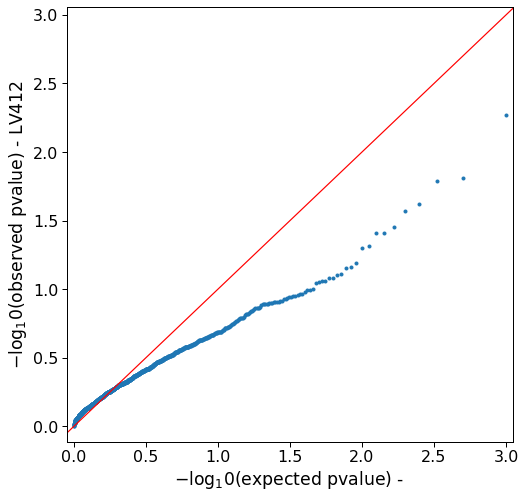

In [103]:
qqplot_unif(results)

**Note**

## LV57

In [104]:
lv_code = "LV57"

In [105]:
results = dfs[dfs["lv"] == lv_code]

In [106]:
results.shape

(1000, 7)

In [107]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
7,LV57,-0.016988,0.009639,-1.762418,0.078046,0.960977,random.pheno988
16,LV57,0.000631,0.009701,0.065050,0.948136,0.474068,random.pheno589
25,LV57,0.020075,0.009615,2.087812,0.036854,0.018427,random.pheno385
34,LV57,-0.003762,0.009735,-0.386429,0.699192,0.650404,random.pheno5
43,LV57,-0.000914,0.009650,-0.094687,0.924567,0.537717,random.pheno74


In [108]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [109]:
show_prop(results, 0.01)

0.009

In [110]:
show_prop(results, 0.05)

0.056

In [111]:
show_prop(results, 0.10)

0.108

In [112]:
show_prop(results, 0.15)

0.152

In [113]:
show_prop(results, 0.20)

0.206

### QQplot

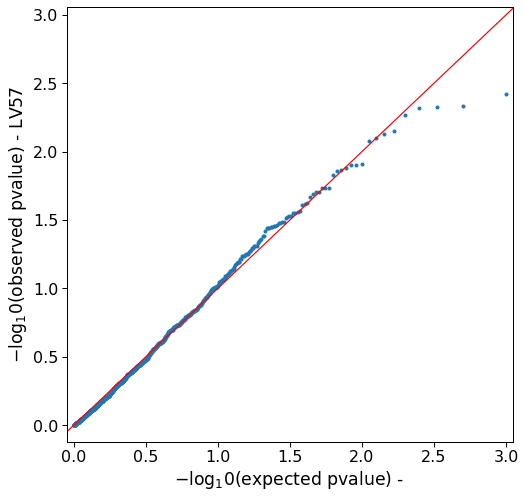

In [114]:
qqplot_unif(results)

## LV647

In [115]:
lv_code = "LV647"

In [116]:
results = dfs[dfs["lv"] == lv_code]

In [117]:
results.shape

(1000, 7)

In [118]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
8,LV647,-0.007585,0.010774,-0.704047,0.481429,0.759285,random.pheno988
17,LV647,0.008222,0.010840,0.758485,0.448188,0.224094,random.pheno589
26,LV647,0.012952,0.010748,1.205115,0.228203,0.114102,random.pheno385
35,LV647,-0.000556,0.010879,-0.051124,0.959228,0.520386,random.pheno5
44,LV647,0.018805,0.010781,1.744266,0.081161,0.040580,random.pheno74


In [119]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [120]:
show_prop(results, 0.01)

0.022

In [121]:
show_prop(results, 0.05)

0.078

In [122]:
show_prop(results, 0.10)

0.116

In [123]:
show_prop(results, 0.15)

0.157

In [124]:
show_prop(results, 0.20)

0.206

### QQplot

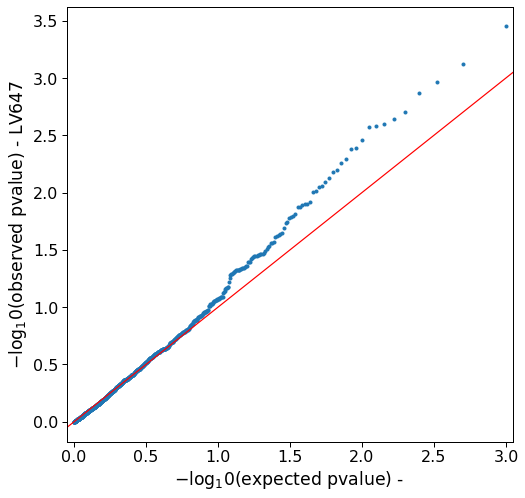

In [125]:
qqplot_unif(results)